## EDA and Data Cleaning

In [33]:
# Import libraries
import pandas as pd
import numpy as np
import gzip as gz
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from zipfile import ZipFile
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor, NearestNeighbors
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, plot_tree
from sklearn.dummy import DummyClassifier
from sklearn.metrics import make_scorer, f1_score, plot_roc_curve, plot_confusion_matrix, classification_report
from sklearn.naive_bayes import MultinomialNB, GaussianNB, BernoulliNB
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, VotingClassifier
from sklearn.decomposition import PCA
from xgboost import XGBClassifier 
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as imbPipeline
from collections import Counter
from statsmodels.api import qqplot
from scipy import stats

In [34]:
# Load and explore dataset
nba = 'NBAInjuries.zip'
with ZipFile(nba, 'r') as zip:
    zip.extractall('nba_unzipped')
    
df = pd.read_csv('nba_unzipped/injuries_2010-2020.csv')
df

,Date,Team,Acquired,Relinquished,Notes
0,2010-10-03,Bulls,NaN,Carlos Boozer,fractured bone in right pinky finger (out indefinitely)
1,2010-10-06,Pistons,NaN,Jonas Jerebko,torn right Achilles tendon (out indefinitely)
2,2010-10-06,Pistons,NaN,Terrico White,broken fifth metatarsal in right foot (out indefinitely)
3,2010-10-08,Blazers,NaN,Jeff Ayres,torn ACL in right knee (out indefinitely)
4,2010-10-08,Nets,NaN,Troy Murphy,strained lower back (out indefinitely)
...,...,...,...,...,...
27100,2020-09-30,Lakers,Dion Waiters,NaN,activated from IL
27101,2020-10-02,Heat,NaN,Bam Adebayo,strained neck (DTD)
27102,2020-10-02,Heat,NaN,Goran Dragic,placed on IL with torn plantar fascia in left foot
27103,2020-10-02,Heat,Chris Silva,NaN,activated from IL


In [35]:
# Drop Acquired column, null values, and rename Relinquished to Name
df.drop(['Acquired'], axis=1, inplace=True)
df.dropna(inplace=True)
df.rename(columns={'Relinquished':'Name'}, inplace=True)
pd.set_option('display.max_colwidth', None)
df.head()

,Date,Team,Name,Notes
0,2010-10-03,Bulls,Carlos Boozer,fractured bone in right pinky finger (out indefinitely)
1,2010-10-06,Pistons,Jonas Jerebko,torn right Achilles tendon (out indefinitely)
2,2010-10-06,Pistons,Terrico White,broken fifth metatarsal in right foot (out indefinitely)
3,2010-10-08,Blazers,Jeff Ayres,torn ACL in right knee (out indefinitely)
4,2010-10-08,Nets,Troy Murphy,strained lower back (out indefinitely)


In [36]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17558 entries, 0 to 27102
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Date    17558 non-null  object
 1   Team    17558 non-null  object
 2   Name    17558 non-null  object
 3   Notes   17558 non-null  object
dtypes: object(4)
memory usage: 685.9+ KB


In [37]:
# Create series of Notes column
s1 = df.Notes

In [38]:
Achilles = s1.str.contains('achilles', case=False)
Achilles.value_counts()

False    17295
True       263
Name: Notes, dtype: int64

In [39]:
# Binary label out_of_season as target
df = df.assign(Achilles=pd.Series(Achilles).values)
df = df*1

# Dataset of injuries that resulted in player being 'out for season'
ach = df[(df['Notes'].str.contains('achilles', case=False))]
ach

,Date,Team,Name,Notes,Achilles
1,2010-10-06,Pistons,Jonas Jerebko,torn right Achilles tendon (out indefinitely),1
5,2010-10-08,Pistons,Jonas Jerebko,surgery to repair torn right Achilles tendon,1
57,2010-10-27,Jazz,Mehmet Okur,placed on IL recovering from surgery to repair torn left Achilles tendon,1
75,2010-10-27,Pistons,Jonas Jerebko,placed on IL recovering from surgery to repair torn right Achilles tendon (out for season),1
209,2010-11-07,76ers,Andre Iguodala,placed on IL with right Achilles tendon injury,1
...,...,...,...,...,...
26465,2020-02-22,Cavaliers,Kevin Love,sore right Achilles (DTD),1
26639,2020-03-06,Bulls,Ryan Arcidiacono,sore right Achilles (out for season),1
26695,2020-03-08,Wizards,Jerome Robinson,left Achilles injury (DTD),1
26826,2020-08-01,Heat,K.Z. Okpala,placed on IL with Achilles injury,1


In [40]:
# Split injury data by season
ach_10 = ach[(ach['Date'] < '2011-07-01')]
ach_11 = ach[(ach['Date'].between('2011-07-01','2012-07-01'))]
ach_12 = ach[(ach['Date'].between('2012-07-01','2013-07-01'))]
ach_13 = ach[(ach['Date'].between('2013-07-01','2014-07-01'))]
ach_14 = ach[(ach['Date'].between('2014-07-01','2015-07-01'))]
ach_15 = ach[(ach['Date'].between('2015-07-01','2016-07-01'))]
ach_16 = ach[(ach['Date'].between('2016-07-01','2017-07-01'))]
ach_17 = ach[(ach['Date'].between('2017-07-01','2018-07-01'))]
ach_18 = ach[(ach['Date'].between('2018-07-01','2019-07-01'))]

In [41]:
ach_18.head()

,Date,Team,Name,Notes,Achilles
22257,2018-09-21,Pacers,C.J. Wilcox,placed on IL with torn right Achilles tendon (out for season),1
22258,2018-09-24,Warriors,DeMarcus Cousins,recovering from surgery to repair torn left Achilles tendon (out indefinitely),1
22280,2018-10-16,Warriors,DeMarcus Cousins,placed on IL with recovering from surgery to repair torn left Achilles tendon,1
22674,2018-11-15,Hawks,Taurean Prince,right Achilles injury (DTD),1
22698,2018-11-17,Hawks,Taurean Prince,placed on IL with right Achilles injury,1


Multiple entries for same player and injury are noted. The duplicates need to be removed.

In [42]:
# Function to drop duplicates
def DropDuplicates(dataset):
    return dataset.drop_duplicates(subset=['Name'], inplace=True)

# Make list of season datasets
list_ofs = [ach_10, ach_11, ach_12, ach_13, ach_14, ach_15,
            ach_16, ach_17, ach_18]

# Apply function
[DropDuplicates(season) for season in list_ofs]

<ipython-input-42-df1a0279acf4>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return dataset.drop_duplicates(subset=['Name'], inplace=True)


[None, None, None, None, None, None, None, None, None]

Import NBA player stats

In [43]:
# Import player stats
p09 = pd.read_excel('player_stats/2009-2010.xlsx')
p10 = pd.read_excel('player_stats/2010-2011.xlsx')
p11 = pd.read_excel('player_stats/2011-2012.xlsx')
p12 = pd.read_excel('player_stats/2012-2013.xlsx')
p13 = pd.read_excel('player_stats/2013-2014.xlsx')
p14 = pd.read_excel('player_stats/2014-2015.xlsx')
p15 = pd.read_excel('player_stats/2015-2016.xlsx')
p16 = pd.read_excel('player_stats/2016-2017.xlsx')
p17 = pd.read_excel('player_stats/2017-2018.xlsx')

In [44]:
# Merge stats dataset with injury dataset
s09 = pd.merge(p09,ach_10, how='left', on='Name')
s10 = pd.merge(p10,ach_11, how='left', on='Name')
s11 = pd.merge(p11,ach_12, how='left', on='Name')
s12 = pd.merge(p12,ach_13, how='left', on='Name')
s13 = pd.merge(p13,ach_14, how='left', on='Name')
s14 = pd.merge(p14,ach_15, how='left', on='Name')
s15 = pd.merge(p15,ach_16, how='left', on='Name')
s16 = pd.merge(p16,ach_17, how='left', on='Name')
s17 = pd.merge(p17,ach_18, how='left', on='Name')

In [45]:
# Concatenate season datasets into main dataset
df_con = pd.concat([s09,s10,s11,s12,s13,s14,s15,s16,s17], axis=0)
pd.set_option('display.max_columns', None)
df_con.head()

,Name,TEAM,AGE,HEIGHT,WEIGHT,COLLEGE,COUNTRY,DRAFT YEAR,DRAFT ROUND,DRAFT NUMBER,GP,NETRTG,TS%,W,L,MPG,PTS,FGM,FGA,FG%,3PM,3PA,3P%,FTM,FTA,FT%,OREB,DREB,REB,AST,TOV,STL,BLK,PF,FP,DD2,TD3,+/-,MIN,USG%,%FGM,%FGA,%3PM,%3PA,%FTM,%FTA,%OREB,%DREB,%REB,%AST,%TOV,%STL,%BLK,%BLKA,%PF,%PFD,%PTS,Date,Team,Notes,Achilles
0,Aaron Brooks,HOU,25,6-1,161,Oregon,USA,2007,1,26,82,0.2,0.549,42,40,35.6,19.6,7.0,16.2,43.2,2.5,6.4,39.8,3.0,3.6,82.2,0.7,2.0,2.6,5.3,2.8,0.8,0.2,2.4,30.9,6,0,-0.3,2919,25.4,25.1,26.2,41.5,37.8,22.5,21.1,8.1,8.8,8.6,32.7,27.0,16.2,6.2,21.3,16.3,19.7,26.0,NaN,NaN,NaN,NaN
1,Aaron Gray,NOH,25,7-1,270,Pittsburgh,USA,2007,2,49,32,-3.1,0.551,11,21,9.7,3.3,1.3,2.6,51.2,0.0,0.0,0.0,0.6,0.9,71.4,1.4,1.9,3.3,0.7,0.6,0.3,0.3,1.7,9.6,0,0,-0.4,311,16.0,17.2,15.4,0.0,0.0,21.5,23.1,52.3,30.8,37.3,16.5,18.0,18.0,35.5,25.0,37.5,18.5,16.9,NaN,NaN,NaN,NaN
2,Acie Law,CHI,25,6-3,202,Texas A&M,USA,2007,1,11,26,5.3,0.585,11,15,9.0,4.3,1.3,2.9,46.7,0.2,0.6,31.3,1.5,1.9,77.6,0.1,0.5,0.7,1.0,0.7,0.4,0.0,0.6,7.4,0,0,0.8,234,21.4,18.6,19.4,14.7,18.4,29.9,30.4,6.1,10.3,9.2,26.0,29.8,24.4,4.2,39.4,14.0,27.8,21.0,NaN,NaN,NaN,NaN
3,Adam Morrison,LAL,25,6-8,205,Gonzaga,USA,2006,1,3,31,-8.3,0.418,23,8,7.8,2.4,1.0,2.7,37.6,0.2,0.7,23.8,0.2,0.3,62.5,0.3,0.7,1.0,0.6,0.3,0.1,0.1,0.5,4.7,0,0,-1.2,241,17.8,17.7,20.1,13.9,21.2,6.8,7.7,16.4,13.6,14.3,16.8,13.9,10.0,8.0,30.0,20.2,5.8,15.7,NaN,NaN,NaN,NaN
4,AJ Price,IND,23,6-2,181,Connecticut,USA,2009,2,52,56,3.9,0.530,23,33,15.5,7.3,2.6,6.3,41.0,1.1,3.1,34.5,1.1,1.3,80.0,0.2,1.4,1.6,1.9,1.1,0.6,0.1,0.9,13.0,0,0,0.9,865,21.9,21.3,23.2,32.4,34.3,19.2,18.0,7.4,13.4,12.1,27.4,21.5,25.5,3.2,23.8,13.6,20.2,22.0,NaN,NaN,NaN,NaN


Let the data cleaning begin

In [46]:
# Function to convert ft-in height into inches
def parse_ht(height):
    ht_ = height.split("-")
    ft_ = int(ht_[0])
    in_ = int(ht_[1])
    return (12*ft_) + in_
df_con["HEIGHT"] = df_con["HEIGHT"].apply(lambda x:parse_ht(x))

In [47]:
# Binary bin Country['USA'] = 1, other = 0
df_con.COUNTRY.replace(to_replace='USA', value=1, inplace=True) 
df_con.loc[df_con['COUNTRY'] != 1, 'COUNTRY'] = 0
df_con['COUNTRY'] = df_con['COUNTRY'].astype(int)
df_con.COUNTRY.value_counts()

1    3456
0     861
Name: COUNTRY, dtype: int64

In [48]:
# Binary bin College = 1 , no College = 0
df_con.COLLEGE.replace(to_replace='None', value=0, inplace=True)
df_con.loc[df_con['COLLEGE'] != 0, 'COLLEGE'] = 1
df_con['COLLEGE'] = df_con['COLLEGE'].astype(int)
df_con.COLLEGE.value_counts()

1    3572
0     745
Name: COLLEGE, dtype: int64

In [50]:
# Replace Undrafted and Nan with 0
df_con.replace(to_replace='Undrafted', value=0, inplace=True)
df_con['Achilles'].fillna(0, inplace=True)

In [51]:
# DRAFT YEAR dropped because because undrafted player data was not recorded
df_con.drop('DRAFT YEAR', axis=1, inplace=True)

In [52]:
# Function to convert strings to numeric
def MakeNumeric(Column):
    df_con[Column] = df_con[Column].astype(int)
    return df_con

# Make list of columns to be convert to numeric values
make_columns_numeric = ['COUNTRY', 'COLLEGE', 'DRAFT ROUND', 'DRAFT NUMBER']

# Apply function
[MakeNumeric(column) for column in make_columns_numeric]

[              Name TEAM  AGE  HEIGHT  WEIGHT  COLLEGE  COUNTRY  DRAFT ROUND  \
 0     Aaron Brooks  HOU   25      73     161        1        1            1   
 1       Aaron Gray  NOH   25      85     270        1        1            2   
 2         Acie Law  CHI   25      75     202        1        1            1   
 3    Adam Morrison  LAL   25      80     205        1        1            1   
 4         AJ Price  IND   23      74     181        1        1            2   
 ..             ...  ...  ...     ...     ...      ...      ...          ...   
 535   Zach Collins  POR   20      85     230        1        1            1   
 536    Zach LaVine  CHI   23      77     185        1        1            1   
 537  Zach Randolph  SAC   36      81     250        1        1            1   
 538  Zaza Pachulia  GSW   34      83     270        0        0            2   
 539        Zhou Qi  HOU   22      85     210        0        0            2   
 
      DRAFT NUMBER  GP  NETRTG    TS% 

Now let's do a heatmap to check for multicollinearity

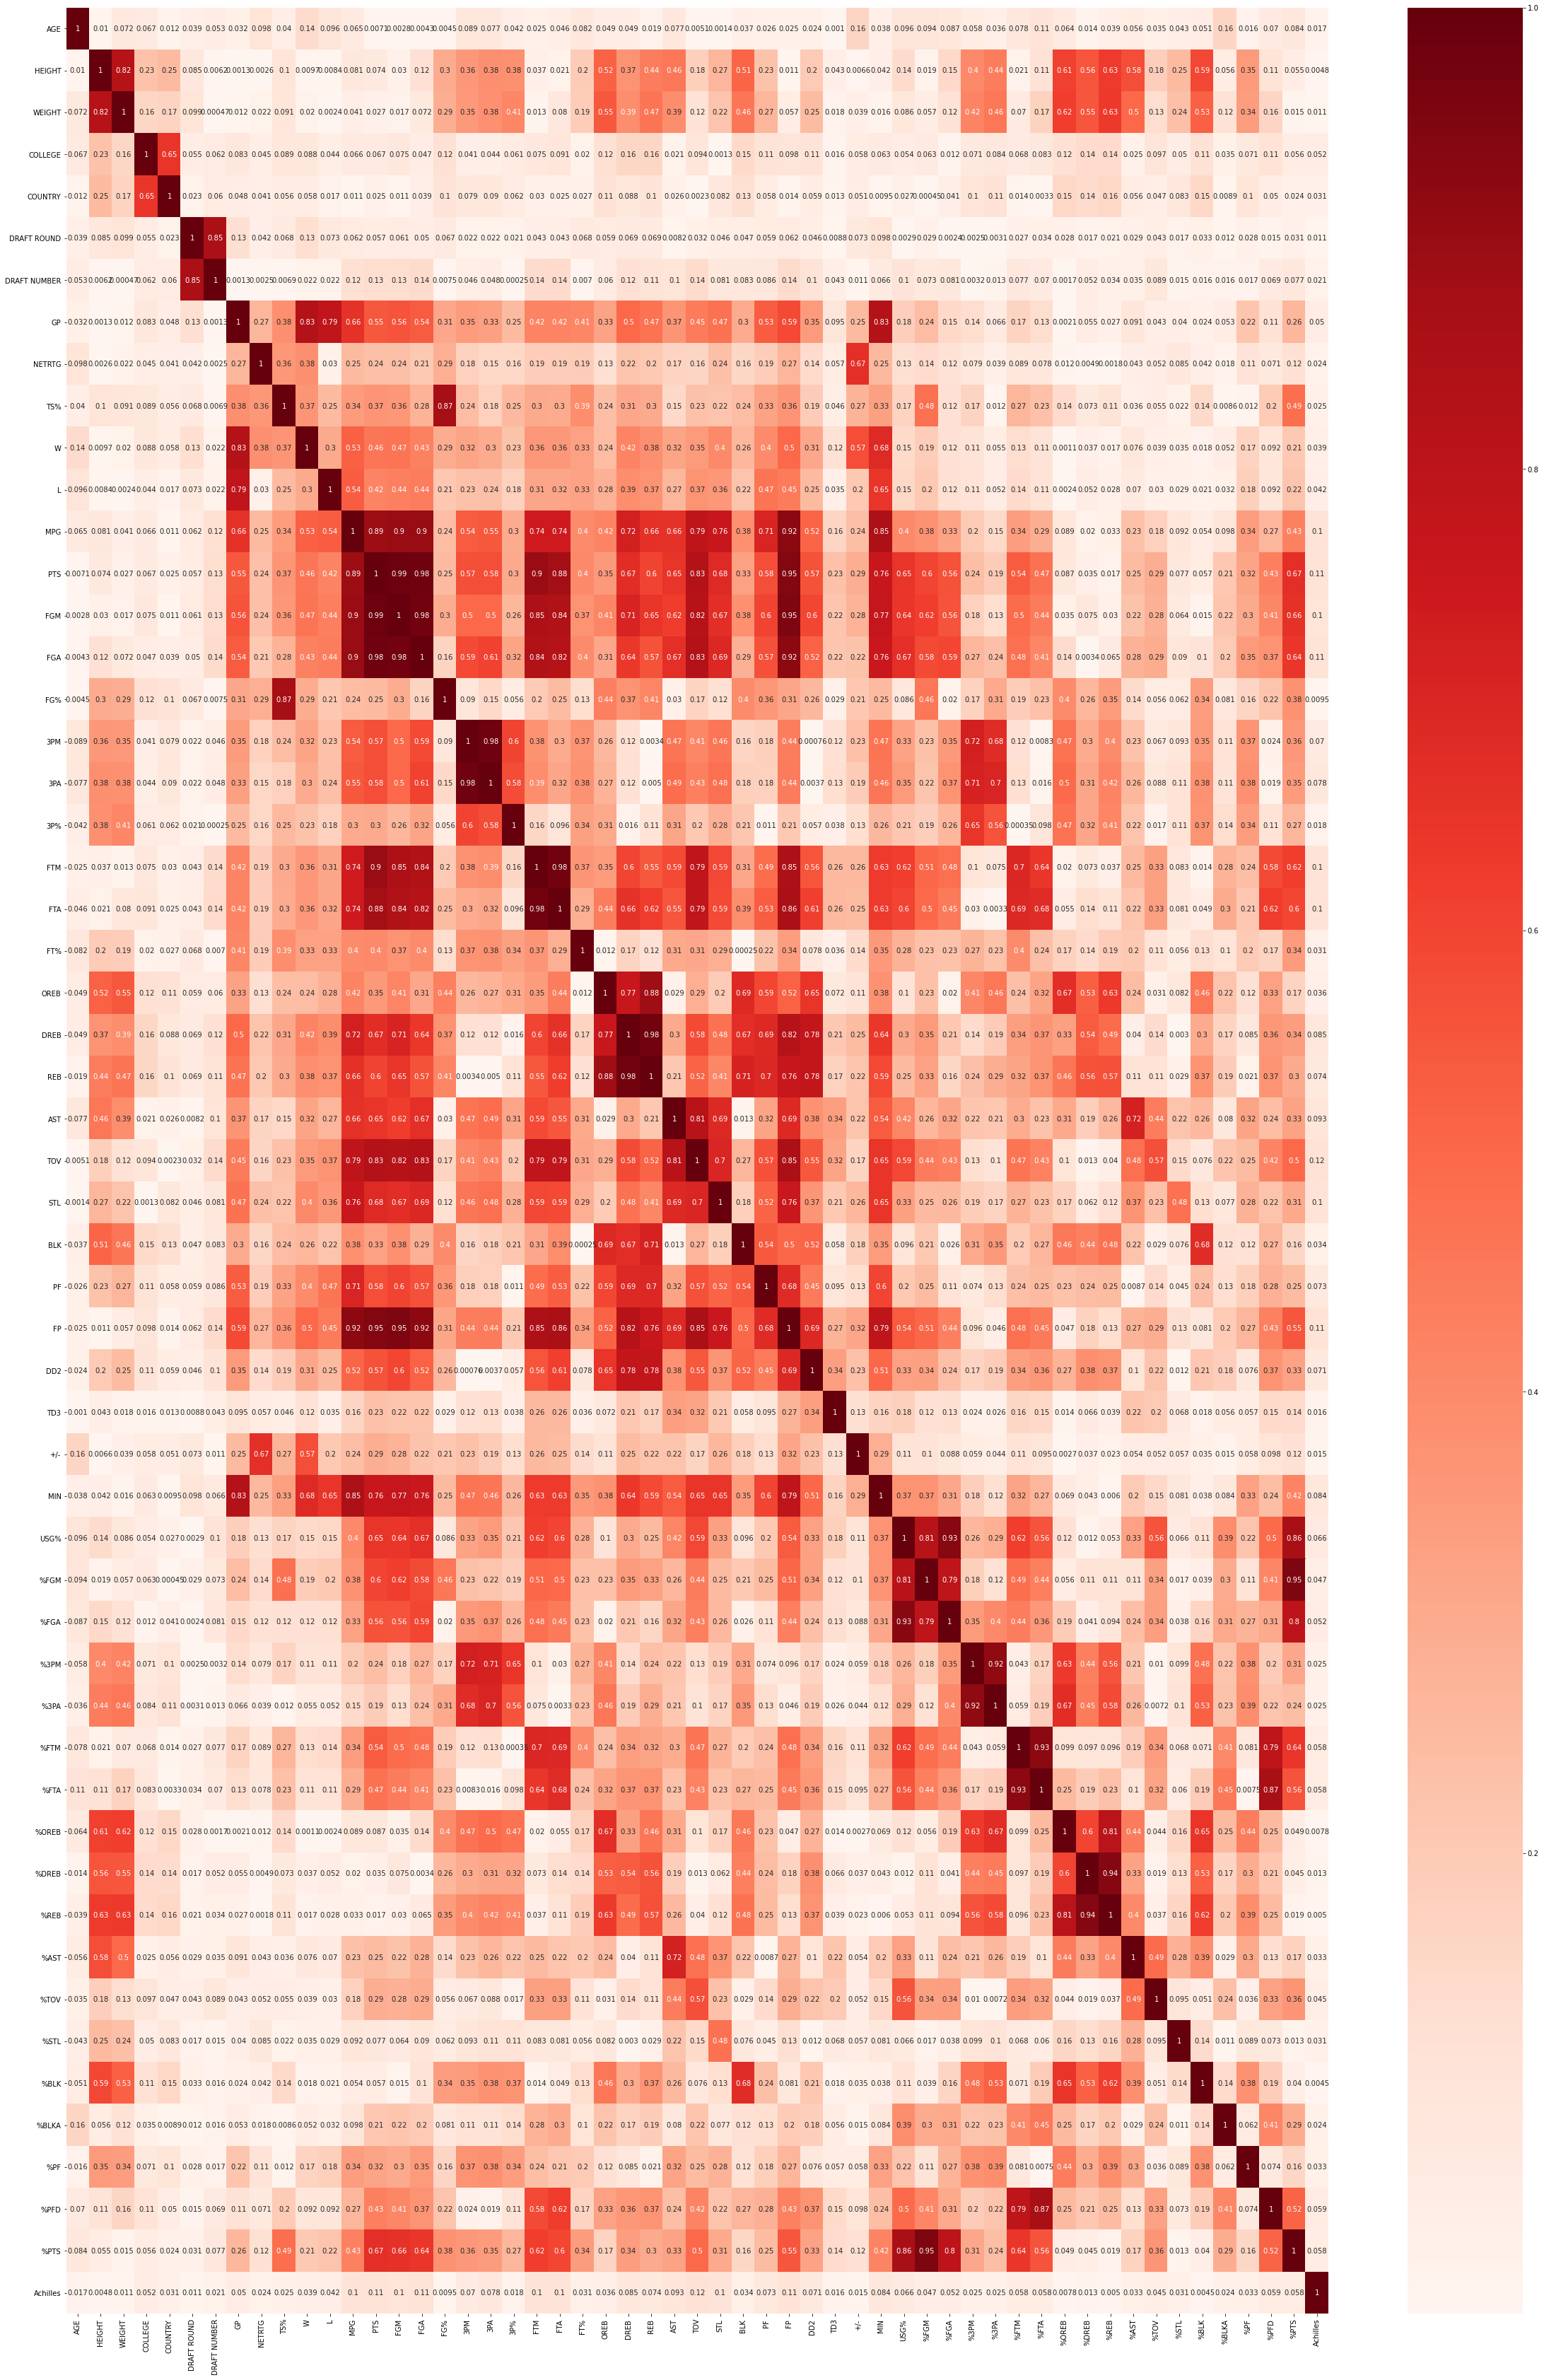

In [53]:
# Heatmap to display data correlations
CORR = df_con.corr().abs()
fig, ax=plt.subplots(figsize=(40,60))
sns.heatmap(CORR, cmap='Reds', annot=True);

Using a pearson correlation coefficient cutoff of 0.85, here we see that (draft round, draft number), (true shooting percentage, field goal percentage), (minutes per game, minutes played), (minutes per game, points per game), (minutes per game, field goals made), (minutes per game, field goals attempted), (3pt made, 3pt attempted), (free throws made, points per game), (free throws made, field goals made), (free throws made, free throws attempted), (free throws attempted, free throws attempted), (free throws attempted, points per game), (offensive rebounds, rebounds), (defensive rebounds, rebounds), (fantasy points, minutes per game), (fantasy points, points per game), (fantasy points, field goals made), (fantasy points, field goals attempted), (fantasy points, free throws made), (fantasy points, free throws attempted), (fantasy points, turnovers), (usage percentage, percent of team’s field goals attempted), (percent of team’s 3pt made, percent of team’s 3pt attempted), (percent of team’s free throws made, percent of team’s free throws attempted), (percent of team’s defensive rebounds, percent of team’s rebounds), (usage percentage, percent of team’s points scored), (percent of team’s field goals made, percent of team’s points scored), (percent of team’s personal fouls drawn, percent of team’s free throws attempted) demonstrate high multicollinearity

# PCA vs feature elimination???

In [54]:
# Dummify Teams
df_con = pd.get_dummies(df_con, columns=['TEAM'], drop_first=True)
df_con

,Name,AGE,HEIGHT,WEIGHT,COLLEGE,COUNTRY,DRAFT ROUND,DRAFT NUMBER,GP,NETRTG,TS%,W,L,MPG,PTS,FGM,FGA,FG%,3PM,3PA,3P%,FTM,FTA,FT%,OREB,DREB,REB,AST,TOV,STL,BLK,PF,FP,DD2,TD3,+/-,MIN,USG%,%FGM,%FGA,%3PM,%3PA,%FTM,%FTA,%OREB,%DREB,%REB,%AST,%TOV,%STL,%BLK,%BLKA,%PF,%PFD,%PTS,Date,Team,Notes,Achilles,TEAM_BKN,TEAM_BOS,TEAM_CHA,TEAM_CHI,TEAM_CLE,TEAM_DAL,TEAM_DEN,TEAM_DET,TEAM_GSW,TEAM_HOU,TEAM_IND,TEAM_LAC,TEAM_LAL,TEAM_MEM,TEAM_MIA,TEAM_MIL,TEAM_MIN,TEAM_NJN,TEAM_NOH,TEAM_NOP,TEAM_NYK,TEAM_OKC,TEAM_ORL,TEAM_PHI,TEAM_PHX,TEAM_POR,TEAM_SAC,TEAM_SAS,TEAM_TOR,TEAM_UTA,TEAM_WAS
0,Aaron Brooks,25,73,161,1,1,1,26,82,0.2,0.549,42,40,35.6,19.6,7.0,16.2,43.2,2.5,6.4,39.8,3.0,3.6,82.2,0.7,2.0,2.6,5.3,2.8,0.8,0.2,2.4,30.9,6,0,-0.3,2919,25.4,25.1,26.2,41.5,37.8,22.5,21.1,8.1,8.8,8.6,32.7,27.0,16.2,6.2,21.3,16.3,19.7,26.0,NaN,NaN,NaN,0.0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,Aaron Gray,25,85,270,1,1,2,49,32,-3.1,0.551,11,21,9.7,3.3,1.3,2.6,51.2,0.0,0.0,0.0,0.6,0.9,71.4,1.4,1.9,3.3,0.7,0.6,0.3,0.3,1.7,9.6,0,0,-0.4,311,16.0,17.2,15.4,0.0,0.0,21.5,23.1,52.3,30.8,37.3,16.5,18.0,18.0,35.5,25.0,37.5,18.5,16.9,NaN,NaN,NaN,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
2,Acie Law,25,75,202,1,1,1,11,26,5.3,0.585,11,15,9.0,4.3,1.3,2.9,46.7,0.2,0.6,31.3,1.5,1.9,77.6,0.1,0.5,0.7,1.0,0.7,0.4,0.0,0.6,7.4,0,0,0.8,234,21.4,18.6,19.4,14.7,18.4,29.9,30.4,6.1,10.3,9.2,26.0,29.8,24.4,4.2,39.4,14.0,27.8,21.0,NaN,NaN,NaN,0.0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,Adam Morrison,25,80,205,1,1,1,3,31,-8.3,0.418,23,8,7.8,2.4,1.0,2.7,37.6,0.2,0.7,23.8,0.2,0.3,62.5,0.3,0.7,1.0,0.6,0.3,0.1,0.1,0.5,4.7,0,0,-1.2,241,17.8,17.7,20.1,13.9,21.2,6.8,7.7,16.4,13.6,14.3,16.8,13.9,10.0,8.0,30.0,20.2,5.8,15.7,NaN,NaN,NaN,0.0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,AJ Price,23,74,181,1,1,2,52,56,3.9,0.530,23,33,15.5,7.3,2.6,6.3,41.0,1.1,3.1,34.5,1.1,1.3,80.0,0.2,1.4,1.6,1.9,1.1,0.6,0.1,0.9,13.0,0,0,0.9,865,21.9,21.3,23.2,32.4,34.3,19.2,18.0,7.4,13.4,12.1,27.4,21.5,25.5,3.2,23.8,13.6,20.2,22.0,NaN,NaN,NaN,0.0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
535,Zach Collins,20,85,230,1,1,1,10,66,1.3,0.475,41,25,15.8,4.4,1.7,4.4,39.8,0.5,1.7,31.0,0.4,0.6,64.3,0.7,2.7,3.3,0.8,0.9,0.3,0.5,2.0,10.9,0,0,0.2,1045,15.3,13.5,15.7,14.6,18.4,8.8,10.6,20.8,22.8,22.4,12.7,19.3,14.7,34.8,16.2,28.2,12.6,12.9,NaN,NaN,NaN,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
536,Zach LaVine,23,77,185,1,1,1,13,24,-12.1,0.499,9,15,27.3,16.7,5.7,14.8,38.3,1.8,5.1,34.1,3.6,4.5,81.3,0.4,3.5,3.9,3.0,1.8,1.0,0.2,2.3,27.6,0,0,-7.2,656,29.0,26.1,29.5,30.4,30.5,39.2,37.5,7.5,18.4,16.2,24.7,25.1,23.3,8.9,43.5,20.2,28.8,28.6,NaN,NaN,NaN,0.0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
537,Zach Randolph,36,81,250,1,1,1,19,59,-12.2,0.529,18,41,25.6,14.5,6.1,12.9,47.3,0.9,2.5,34.7,1.4,1.8,78.5,1.6,5.1,6.7,2.2,2.0,0.7,0.2,2.0,26.5,8,0,-6.0,1508,27.0,29.3,28.2,18.5,20.3,23.2,21.4,32.6,30.4,30.9,19.1,26.0,18.1,9.5,26.7,19.6,26.1,27.6,NaN,NaN,NaN,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
538,Zaza Pachulia,34,83,270,0,0,2,42,69,9.4,0.612,47,22,14.1,5.4,2.2,3.8,56.4,0.0,0.0,0.0,1.1,1.3,80.6,1.3,3.4,4.7,1.6,1.0,0.6,0.2,1.8,14.7,2,0,2.8,972,16.5,16.1,14.8,0.0,0.2,26.8,28.0,48.4,32.4,35.6,16.3,22.6,24.4,15.0,39.8,36.6,27.5,15.5,2019-03-06,Pistons,placed on IL with right Achilles injury,1.0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [55]:
df_con.describe()

,AGE,HEIGHT,WEIGHT,COLLEGE,COUNTRY,DRAFT ROUND,DRAFT NUMBER,GP,NETRTG,TS%,W,L,MPG,PTS,FGM,FGA,FG%,3PM,3PA,3P%,FTM,FTA,FT%,OREB,DREB,REB,AST,TOV,STL,BLK,PF,FP,DD2,TD3,+/-,MIN,USG%,%FGM,%FGA,%3PM,%3PA,%FTM,%FTA,%OREB,%DREB,%REB,%AST,%TOV,%STL,%BLK,%BLKA,%PF,%PFD,%PTS,Achilles,TEAM_BKN,TEAM_BOS,TEAM_CHA,TEAM_CHI,TEAM_CLE,TEAM_DAL,TEAM_DEN,TEAM_DET,TEAM_GSW,TEAM_HOU,TEAM_IND,TEAM_LAC,TEAM_LAL,TEAM_MEM,TEAM_MIA,TEAM_MIL,TEAM_MIN,TEAM_NJN,TEAM_NOH,TEAM_NOP,TEAM_NYK,TEAM_OKC,TEAM_ORL,TEAM_PHI,TEAM_PHX,TEAM_POR,TEAM_SAC,TEAM_SAS,TEAM_TOR,TEAM_UTA,TEAM_WAS
count,4317.000000,4317.000000,4317.000000,4317.000000,4317.000000,4317.000000,4317.000000,4317.000000,4317.000000,4317.000000,4317.000000,4317.000000,4317.000000,4317.000000,4317.000000,4317.000000,4317.000000,4317.000000,4317.000000,4317.000000,4317.000000,4317.000000,4317.000000,4317.000000,4317.000000,4317.000000,4317.000000,4317.000000,4317.000000,4317.000000,4317.000000,4317.000000,4317.000000,4317.000000,4317.000000,4317.000000,4317.000000,4317.000000,4317.000000,4317.000000,4317.000000,4317.000000,4317.000000,4317.000000,4317.000000,4317.000000,4317.000000,4317.000000,4317.000000,4317.000000,4317.000000,4317.000000,4317.000000,4317.000000,4317.000000,4317.000000,4317.000000,4317.000000,4317.000000,4317.000000,4317.000000,4317.000000,4317.000000,4317.000000,4317.000000,4317.00000,4317.000000,4317.000000,4317.000000,4317.000000,4317.000000,4317.000000,4317.000000,4317.000000,4317.000000,4317.000000,4317.000000,4317.000000,4317.000000,4317.000000,4317.000000,4317.000000,4317.000000,4317.000000,4317.000000,4317.000000
mean,26.962474,79.158907,221.557331,0.827426,0.800556,1.056521,17.999305,52.444753,-2.139958,0.515802,26.248552,26.196201,20.206185,8.198193,3.071253,6.844174,43.816817,0.641209,1.832708,25.254969,1.418346,1.885685,70.110100,0.901158,2.645217,3.544035,1.800556,1.150961,0.635441,0.405513,1.746583,17.117443,4.237433,0.118601,-0.345587,1213.017836,18.136808,18.260459,18.699884,17.300695,18.111026,17.341788,17.885013,20.508548,19.694811,19.985268,18.098494,18.254413,19.262868,19.996965,19.168334,22.005606,18.362613,18.105791,0.019226,0.023859,0.033356,0.033588,0.031735,0.034978,0.034746,0.032198,0.031040,0.032198,0.033125,0.03243,0.033356,0.033820,0.036368,0.033125,0.034283,0.032662,0.012509,0.015288,0.020848,0.033820,0.033356,0.031040,0.034051,0.032198,0.031503,0.032198,0.033588,0.033125,0.032662,0.034051
std,4.262036,3.553347,26.616005,0.377922,0.399629,0.638981,16.163703,24.696246,11.887091,0.097981,15.968330,14.620618,9.457667,5.742736,2.096509,4.436207,9.832629,0.695200,1.816217,16.981427,1.338567,1.664693,19.822599,0.809434,1.769777,2.446181,1.778900,0.778435,0.428340,0.438700,0.751397,10.486305,9.174975,1.071935,2.927873,857.427097,5.197265,6.358304,5.841734,15.369848,14.433505,10.430400,10.074568,15.437418,8.832157,9.685951,12.663147,8.054364,9.776307,17.953947,11.251355,8.907587,8.941240,6.191234,0.137335,0.152628,0.179587,0.180187,0.175314,0.183745,0.183158,0.176547,0.173446,0.176547,0.178983,0.17716,0.179587,0.180786,0.187225,0.178983,0.181976,0.177770,0.111153,0.122712,0.142891,0.180786,0.179587,0.173446,0.181382,0.176547,0.174694,0.176547,0.180187,0.178983,0.177770,0.181382
min,19.000000,65.000000,133.000000,0.000000,0.000000,0.000000,0.000000,1.000000,-150.000000,0.000000,0.000000,0.000000,0.100000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.800000,0.000000,0.000000,-19.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,24.00000

## Modeling

Assign X and y values, train_test_split, scale data

In [56]:
# Assign X and y. 
y = df_con.Achilles
X = df_con.drop(['Name', 'Date', 'Team', 'Notes', 'Achilles'], axis=1) 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=22) 

# Scale data
scale = StandardScaler()
X_train_scaled = scale.fit_transform(X_train)
X_test_scaled = scale.transform(X_test)

In [57]:
# Assess target balance
y.value_counts()

0.0    4234
1.0      83
Name: Achilles, dtype: int64

Given the target variable imbalance will elect to use f1_score as primary metric along with ROC AUC as a secondary metric

### SMOTE attempt

In [58]:
# sm = SMOTE(random_state=22)
# X_train_smote, y_train_smote = sm.fit_resample(X_train_scaled, y_train)

# counter = Counter(y_train)
# smote_counter = Counter(y_train_smote)
# print(counter)
# print(smote_counter)

### Feature Importance: ExtraTreesClassifier

[1.85805188e-02 1.53917716e-02 2.11868355e-02 9.94753658e-03
 7.77475792e-03 9.42487443e-03 1.21427055e-02 1.70452911e-02
 1.74827075e-02 1.66079134e-02 1.62297973e-02 1.70960110e-02
 1.72419862e-02 1.78771450e-02 1.58413612e-02 1.67179952e-02
 1.96892415e-02 1.34689721e-02 1.80274479e-02 1.42305309e-02
 1.98939703e-02 1.85818195e-02 1.72692209e-02 1.57832114e-02
 1.58480359e-02 1.50213201e-02 1.79699297e-02 1.96485139e-02
 1.88273769e-02 1.81300440e-02 1.61438108e-02 1.68251238e-02
 1.53503988e-02 6.04779920e-03 1.82928152e-02 1.80180953e-02
 1.69782063e-02 1.59509476e-02 1.75575500e-02 1.54154665e-02
 1.29985494e-02 1.80604602e-02 1.93580296e-02 1.44631473e-02
 1.67781541e-02 1.69597567e-02 1.49092174e-02 1.82551576e-02
 1.72693912e-02 1.57349028e-02 1.67295439e-02 1.93125873e-02
 1.95159461e-02 1.71996248e-02 3.18791027e-05 5.86938174e-03
 6.24258571e-03 1.49845352e-03 4.56357163e-03 2.11767713e-03
 2.67869230e-03 1.02293809e-02 5.29286016e-03 1.37469206e-03
 2.87503828e-03 5.326276

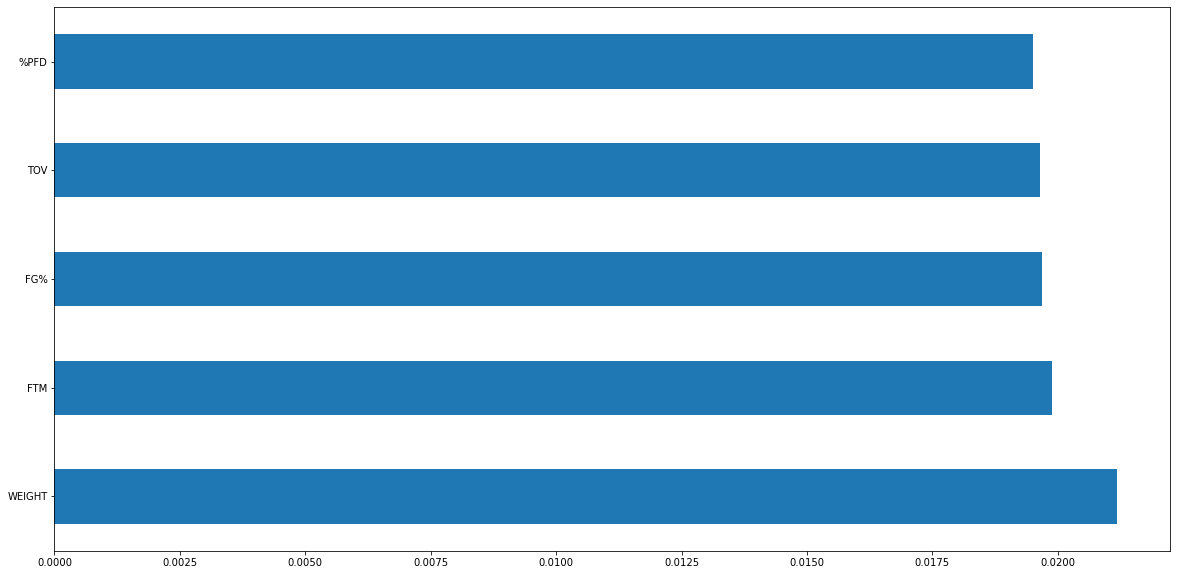

In [59]:
# Use ExtraTreesClassifier to identify important features
etc = ExtraTreesClassifier()
etc.fit(X,y)
print(etc.feature_importances_) 

# Plot bar graph for visualization
feat_importances = pd.Series(etc.feature_importances_, index=X.columns)
feat_importances.nlargest(5).plot(kind='barh', figsize=(20,10))
plt.show()

### Model 0: DummyClassifier Baseline Model

/Users/Hyoyeon/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train:               precision    recall  f1-score   support

         0.0       0.98      1.00      0.99      3175
         1.0       0.00      0.00      0.00        62

    accuracy                           0.98      3237
   macro avg       0.49      0.50      0.50      3237
weighted avg       0.96      0.98      0.97      3237

Test:               precision    recall  f1-score   support

         0.0       0.98      1.00      0.99      1059
         1.0       0.00      0.00      0.00        21

    accuracy                           0.98      1080
   macro avg       0.49      0.50      0.50      1080
weighted avg       0.96      0.98      0.97      1080



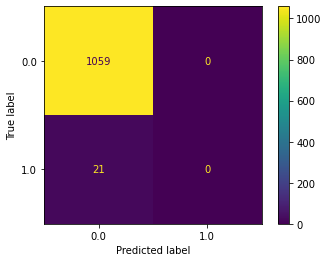

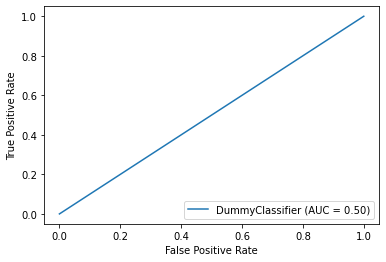

In [60]:
# Instantiate, fit, and run dummy model
dc = DummyClassifier(strategy="most_frequent", random_state=22)
dc.fit(X_train_scaled, y_train)
y_hat_train = dc.predict(X_train_scaled)
y_hat_test = dc.predict(X_test_scaled)
print(f'Train: {classification_report(y_train, y_hat_train)}')
print(f'Test: {classification_report(y_test, y_hat_test)}')

# Plot confusion matrix and ROC AUC for dummy model
plot_confusion_matrix(dc, X_test_scaled, y_test)
plot_roc_curve(dc, X_test_scaled, y_test);

### Model 1: Logistic Regression Model

Train:               precision    recall  f1-score   support

         0.0       0.98      1.00      0.99      3175
         1.0       0.00      0.00      0.00        62

    accuracy                           0.98      3237
   macro avg       0.49      0.50      0.50      3237
weighted avg       0.96      0.98      0.97      3237

Test:               precision    recall  f1-score   support

         0.0       0.98      1.00      0.99      1059
         1.0       0.00      0.00      0.00        21

    accuracy                           0.98      1080
   macro avg       0.49      0.50      0.50      1080
weighted avg       0.96      0.98      0.97      1080

[[1.08271308 0.69081674 1.51275082 0.76700036 0.94299086 1.34418423
  0.7119583  0.93597313 1.38386202 1.11838725 1.16886798 0.75458038
  0.56329914 0.7776643  0.61042951 2.26920236 0.95443822 0.84110206
  1.62112374 0.86616222 1.8600662  0.5332371  1.06429093 1.03528559
  0.92216469 1.18799001 1.39351566 1.5825486  1.08463031 0.93

/Users/Hyoyeon/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/Hyoyeon/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,odds
FGA,2.269202
FTM,1.860066
3PA,1.621124
TOV,1.582549
PF,1.570488


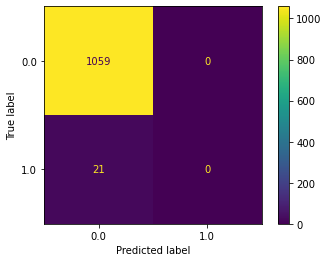

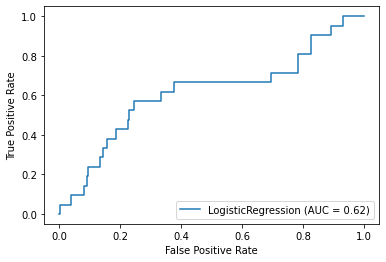

In [61]:
# Instantiate, fit, and run model
lr = LogisticRegression(random_state=22)
lr.fit(X_train_scaled, y_train)
y_hat_train = lr.predict(X_train_scaled)
y_hat_test = lr.predict(X_test_scaled)
print(f'Train: {classification_report(y_train, y_hat_train)}')
print(f'Test: {classification_report(y_test, y_hat_test)}')

# Plot confusion matrix and ROC AUC
plot_confusion_matrix(lr, X_test_scaled, y_test)
plot_roc_curve(lr, X_test_scaled, y_test);

# Print odds ratios and identify top 5 risk factors
print(np.exp(lr.coef_))
COEF = np.exp(lr.coef_[0])
odds = pd.DataFrame(COEF, X.columns, 
        columns=['odds']).sort_values(by='odds', ascending=False)
odds.head()

Here we see the 5 largest prior season risk factors for sustaining season-ending injuries are:
1. Percent of Team's Points
2. Rebounds per Game
3. Percent of Team's Total Rebounds
4. Field goals made per Game
5. Draft round

### PCA

Now that we have identified the risk factors we will reduce the complexity of our data by using principal component analysis. 

In [62]:
pca = PCA(n_components=10) 
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)
pca.explained_variance_ratio_

array([0.18467235, 0.1089662 , 0.04805163, 0.03237297, 0.0259723 ,
       0.02239884, 0.020843  , 0.01963448, 0.01701223, 0.01476483])

Train:               precision    recall  f1-score   support

         0.0       0.98      1.00      0.99      3175
         1.0       0.00      0.00      0.00        62

    accuracy                           0.98      3237
   macro avg       0.49      0.50      0.50      3237
weighted avg       0.96      0.98      0.97      3237

Test:               precision    recall  f1-score   support

         0.0       0.98      1.00      0.99      1059
         1.0       0.00      0.00      0.00        21

    accuracy                           0.98      1080
   macro avg       0.49      0.50      0.50      1080
weighted avg       0.96      0.98      0.97      1080



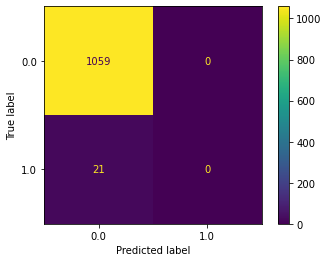

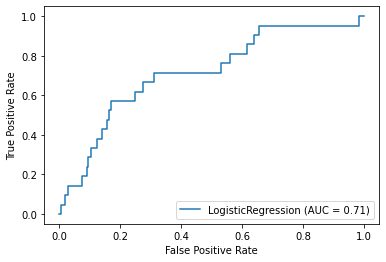

In [63]:
# Instantiate, fit, and run model
lr = LogisticRegression(max_iter = 1000, random_state=22)
lr.fit(X_train_pca, y_train)
y_hat_train = lr.predict(X_train_pca)
y_hat_test = lr.predict(X_test_pca)
print(f'Train: {classification_report(y_train, y_hat_train, zero_division=0)}')
print(f'Test: {classification_report(y_test, y_hat_test, zero_division=0)}')

# Plot confusion matrix and ROC AUC
plot_confusion_matrix(lr, X_test_pca, y_test)
plot_roc_curve(lr, X_test_pca, y_test);

### Model 2: Random Forest Model

Train:               precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      3175
         1.0       1.00      1.00      1.00        62

    accuracy                           1.00      3237
   macro avg       1.00      1.00      1.00      3237
weighted avg       1.00      1.00      1.00      3237

Test:               precision    recall  f1-score   support

         0.0       0.98      1.00      0.99      1059
         1.0       0.00      0.00      0.00        21

    accuracy                           0.98      1080
   macro avg       0.49      0.50      0.50      1080
weighted avg       0.96      0.98      0.97      1080



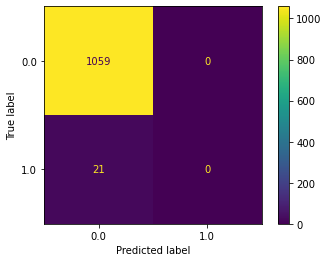

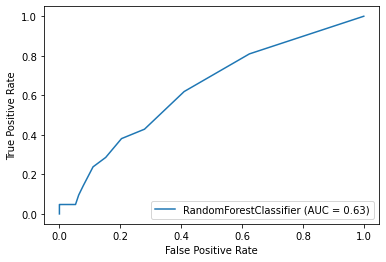

In [64]:
# Instantiate, fit, and run model
rfc = RandomForestClassifier(random_state=22)
rfc.fit(X_train_scaled, y_train)
y_hat_train = rfc.predict(X_train_scaled)
y_hat_test = rfc.predict(X_test_scaled)
print(f'Train: {classification_report(y_train, y_hat_train, zero_division=0)}')
print(f'Test: {classification_report(y_test, y_hat_test, zero_division=0)}')

# Plot confusion matrix and ROC AUC
plot_confusion_matrix(rfc, X_test_scaled, y_test)
plot_roc_curve(rfc, X_test_scaled, y_test);

### Model 3: XGBoost Model

Train:               precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      3175
         1.0       1.00      1.00      1.00        62

    accuracy                           1.00      3237
   macro avg       1.00      1.00      1.00      3237
weighted avg       1.00      1.00      1.00      3237

Test:               precision    recall  f1-score   support

         0.0       0.98      1.00      0.99      1059
         1.0       0.50      0.05      0.09        21

    accuracy                           0.98      1080
   macro avg       0.74      0.52      0.54      1080
weighted avg       0.97      0.98      0.97      1080



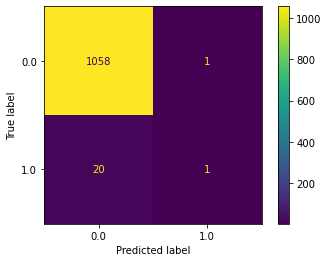

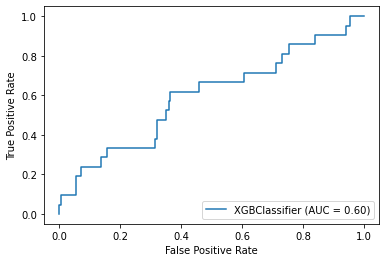

In [65]:
# Instantiate, fit, and run model
xgb = XGBClassifier(random_state=22)
xgb.fit(X_train_scaled, y_train)
y_hat_train = xgb.predict(X_train_scaled)
y_hat_test = xgb.predict(X_test_scaled)
print(f'Train: {classification_report(y_train, y_hat_train, zero_division=0)}')
print(f'Test: {classification_report(y_test, y_hat_test, zero_division=0)}')

# Plot confusion matrix and ROC AUC
plot_confusion_matrix(xgb, X_test_scaled, y_test)
plot_roc_curve(xgb, X_test_scaled, y_test);

### Model 4: Naive Bayes Model

Train:               precision    recall  f1-score   support

         0.0       0.99      0.73      0.84      3175
         1.0       0.04      0.61      0.08        62

    accuracy                           0.73      3237
   macro avg       0.52      0.67      0.46      3237
weighted avg       0.97      0.73      0.83      3237

Test:               precision    recall  f1-score   support

         0.0       0.99      0.71      0.82      1059
         1.0       0.03      0.52      0.06        21

    accuracy                           0.70      1080
   macro avg       0.51      0.62      0.44      1080
weighted avg       0.97      0.70      0.81      1080



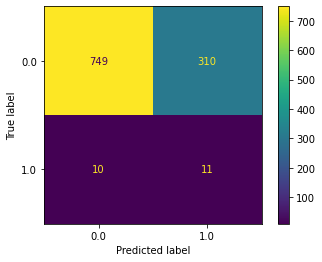

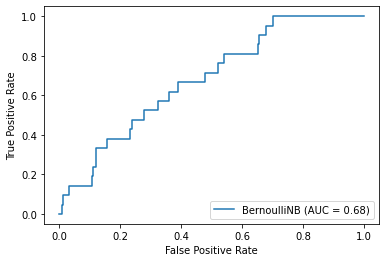

In [66]:
# Instantiate, fit, and run model
bnb = BernoulliNB()
bnb.fit(X_train_scaled, y_train)
y_hat_train = bnb.predict(X_train_scaled)
y_hat_test = bnb.predict(X_test_scaled)
print(f'Train: {classification_report(y_train, y_hat_train, zero_division=0)}')
print(f'Test: {classification_report(y_test, y_hat_test, zero_division=0)}')

# Plot confusion matrix and ROC AUC
plot_confusion_matrix(bnb, X_test_scaled, y_test)
plot_roc_curve(bnb, X_test_scaled, y_test);

### Model 5: Top 3 Ensemble Model

### Pipeline Construction

In [67]:
# # Function with classifier input and pipeline output
# def pipe_maker(classifier):
#     pipe = imbPipeline([('scl', StandardScaler()),('clf', classifier(random_state=22))])
#     return pipe

In [68]:
# # Function with Pipeline & Parameters input and gridsearch with optimum parameters output
# def gridsearch_maker(pipeline, params):
#     f1_scorer = make_scorer(f1_score)
#     return GridSearchCV(estimator=pipeline,
#                         param_grid=params,
#                         scoring=f1_scorer,
#                         cv=5,
#                         n_jobs=-1)

In [69]:
# # Function with pipline/gridsearch input and hyperparameters out for optimized f1_score
# def best_f1(gridsearch):

#     # Instantiate best_f1 object
#     best_f1 = 0.0
    
#     # Fit gridsearch to regularized data set
#     gridsearch.fit(X_train_scaled, y_train)
    
#     # Print best parameters
#     print('Best paramaters are: %s' % gridsearch.best_params_)
    
#     # Print best train f1_score
#     print('Best training f1_score: %.3f' % gridsearch.f1_micro)
    
#     # Prediction on scaled test data
#     y_pred = gridsearch.predict(X_test_scaled)
    
#     # Print test data f1_score with best params
#     print('Test f1_score score with best parameters: %.3f ' % f1_micro(y_test, y_pred))
    
#     # Print confusion matrix and classification report
#     print(confusion_matrix(y_test, y_pred))
#     print(classification_report(y_test, y_pred))
#     print('f1_score score: ', f1_micro(y_test, y_pred))
    
#     # Plot confusion matrix and ROC AUC
#     plot_confusion_matrix(gridsearch, X_test_scaled, y_test,cmap="plasma")
#     plot_roc_curve(dc, X_test_scaled, y_test);

In [70]:
# # Lets try DecisionTreeClassifier and see how that performs.
# pipe_dt = pipe_maker(DummyClassifier)

# # # Creating paramaters
# # grid_params_dt = [{'clf__criterion': ['gini', 'entropy'],
# #                    'clf__min_samples_leaf': leaf_range,
# #                    'clf__max_depth': leaf_range,
# #                    'clf__min_samples_split': split_range}]

# # Creating grid search object
# # gs_dt = gridsearch_maker(pipe_dt, grid_params_dt)

# # Finding best parameters for recall score
# best_f1(pipe_dt)